In [146]:
#Installing all the libraries
import praw
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from empath import Empath
import re
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sindh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sindh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sindh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [147]:
reddit = praw.Reddit(client_id="HSD2DY-UkJP-XmaT97hwiA",
                     client_secret="e9px65SFRjJTXqNLQbILk_lpOa-l_Q",
                     user_agent="linux:my_reddit_bot:v1.0 (by /u/sindhu2111)")

keyword = "Cincinnati Zoo"
submissions = reddit.subreddit("all").search(query=keyword, sort="comments", time_filter="all")

# Create a list of submissions and their comment count
submissions_with_comments = [(submission, submission.num_comments) for submission in submissions]

if submissions_with_comments:
    # Sort the list by the number of comments
    submissions_with_comments.sort(key=lambda x: x[1], reverse=True)

    # Print the top 2 submissions and their subreddits sorted by most comments
    for submission, comments_count in submissions_with_comments[:2]:
        print(submission.subreddit.display_name, "-", comments_count, "comments")
        print(submission.permalink)
    for submission, comments_count in submissions_with_comments[:1]:
        print("top submission: ",submission.permalink)
    url1=submission.permalink
    
else:
    print("No submissions found for the given keyword.")


news - 5973 comments
/r/news/comments/4licqq/cincinnati_zoo_kills_gorilla_to_protect_small/
nottheonion - 4795 comments
/r/nottheonion/comments/4z07o6/harambe_stop_making_memes_of_our_dead_gorilla/
top submission:  /r/news/comments/4licqq/cincinnati_zoo_kills_gorilla_to_protect_small/


In [148]:
url = "https://www.reddit.com"+url1

submission = reddit.submission(url=url)
submission.comments.replace_more(limit=None)

comments = [comment for comment in submission.comments.list()]

# Save raw comments data
raw_data = {
    "Author": [comment.author.name if comment.author else "deleted" for comment in comments],
    "Date": [pd.to_datetime(comment.created_utc, unit="s") for comment in comments],
    "Comment": [comment.body for comment in comments],
    "Subreddit": [comment.subreddit.display_name for comment in comments],
}
raw_df = pd.DataFrame(raw_data)
raw_df.to_csv("Sentimental_analysis_rawdata.csv", index=False)


In [149]:
import pandas as pd
import re
from nltk.corpus import stopwords

unique_authors = set()
stop_words = set(stopwords.words("english"))

def is_comment_from_2016(comment):
    created_year = pd.to_datetime(comment.created_utc, unit="s").year
    return created_year == 2016

def contains_shareable_link(comment):
    regex = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    return bool(re.search(regex, comment))

def preprocess_comment(comment):
    # Remove URLs
    comment = re.sub(r'http\S+', '', comment)

    # Remove punctuation and convert to lowercase
    comment = re.sub(r'[^\w\s]', '', comment).lower()

    # Remove stopwords
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    return comment

filtered_comments = []

for comment in comments:
    if (comment.author not in unique_authors and
        is_comment_from_2016(comment) and
        not comment.body == "[deleted]" and
        not contains_shareable_link(comment.body)):
        
        unique_authors.add(comment.author)
        filtered_comments.append(comment)

preprocessed_comments = [preprocess_comment(comment.body) for comment in filtered_comments]

# Save processed comments data
processed_data = {
    "Author": [comment.author.name if comment.author else "deleted" for comment in filtered_comments],
    "Date": [pd.to_datetime(comment.created_utc, unit="s") for comment in filtered_comments],
    "Comment": preprocessed_comments,
    "Subreddit": [comment.subreddit.display_name for comment in filtered_comments],
}
processed_df = pd.DataFrame(processed_data)
processed_df.to_csv("Sentimental_analysis_processeddata.csv", index=False)


In [150]:
#Perform VADER and EMPATH sentiment analysis
sia = SentimentIntensityAnalyzer()
vader_results = [sia.polarity_scores(comment) for comment in preprocessed_comments]

lexicon = Empath()
empath_results = []
selected_categories = ["love", "hate","joy","play","positive_emotion","trust","aggression","anger","fear","pain","negative_emotion"]
for comment in preprocessed_comments:
        categories = {k: v for k, v in lexicon.analyze(comment, normalize=True).items() if k in selected_categories}
        empath_results.append(categories)
def classify_sentiment(compound_score, very_negative_threshold=-0.5, negative_threshold=-0.05, neutral_threshold=0, positive_threshold=0.05, very_positive_threshold=0.5):
    if compound_score <= very_negative_threshold:
        return "Very Negative"
    elif very_negative_threshold < compound_score <= negative_threshold:
        return "Negative"
    elif negative_threshold < compound_score <= neutral_threshold:
        return "Neutral"
    elif neutral_threshold < compound_score < positive_threshold:
        return "Positive"
    elif positive_threshold <= compound_score < very_positive_threshold:
        return "Very Positive"
    else:
        return "Very Positive"

    
def classify_empath_sentiment(row, selected_categories):
    max_category = max(selected_categories, key=lambda x: row[f"EMPATH_{x}"])
    max_value = row[f"EMPATH_{max_category}"]

    if max_value == 0:
        return "Neutral"

    return max_category.capitalize()

# Prepare data for DataFrame
data = {
    "Author": [comment.author.name if comment.author else "deleted" for comment in filtered_comments],
    "Date": [pd.to_datetime(comment.created_utc, unit="s") for comment in filtered_comments],
    "Comment": preprocessed_comments,
    "Subreddit": [comment.subreddit.display_name for comment in filtered_comments],
    "VADER_neg": [result['neg'] for result in vader_results],
    "VADER_neu": [result['neu'] for result in vader_results],
    "VADER_pos": [result['pos'] for result in vader_results],
    "VADER_compound": [result['compound'] for result in vader_results],
    
}

# Add EMPATH categories to the data dictionary
for category in selected_categories:
    data[f"EMPATH_{category}"] = [result[category] for result in empath_results]

# Create DataFrame
df = pd.DataFrame(data)
df["Overall_VADER_sentiment"] = df["VADER_compound"].apply(classify_sentiment)
df["Overall_EMPATH_sentiment"] = df.apply(lambda row: classify_empath_sentiment(row, selected_categories), axis=1)

# Export the DataFrame to a CSV file
df.to_csv("Sentimental_analysis_VADER_EMPATH.csv", index=False)


In [151]:


# Count the occurrences of each sentiment
sentiment_counts = df["Overall_VADER_sentiment"].value_counts()
print(sentiment_counts)
# Calculate the total number of comments
total_comments = len(df)

# Calculate the average sentiment scores
sentiment_averages = {}
for sentiment in sentiment_counts.index:
    sentiment_averages[sentiment] = sentiment_counts[sentiment] / total_comments

print("Average Sentiment Scores:")
for sentiment, score in sentiment_averages.items():
    print(f"{sentiment}: {score:.3f}")
print()

# Find the most prevalent sentiment
most_prevalent_sentiment = max(sentiment_averages.items(), key=lambda x: x[1])

print(f"Most prevalent sentiment: {most_prevalent_sentiment[0]} (Score: {most_prevalent_sentiment[1]:.3f})")


Very Positive    703
Very Negative    651
Neutral          428
Negative         383
Positive          36
Name: Overall_VADER_sentiment, dtype: int64
Average Sentiment Scores:
Very Positive: 0.319
Very Negative: 0.296
Neutral: 0.194
Negative: 0.174
Positive: 0.016

Most prevalent sentiment: Very Positive (Score: 0.319)


In [152]:
# Count the occurrences of each EMPATH sentiment
empath_sentiment_counts = df["Overall_EMPATH_sentiment"].value_counts()

# Calculate the total number of comments
total_comments = len(df)

# Calculate the average sentiment scores for EMPATH
empath_sentiment_averages = {}
for sentiment in empath_sentiment_counts.index:
    empath_sentiment_averages[sentiment] = empath_sentiment_counts[sentiment] / total_comments

print("EMPATH Average Sentiment Scores:")
for sentiment, score in empath_sentiment_averages.items():
    print(f"{sentiment}: {score:.3f}")
most_prevalent_empath_sentiment = max(empath_sentiment_averages.items(), key=lambda x: x[1])

print(f"Most prevalent EMPATH sentiment: {most_prevalent_empath_sentiment[0]} (Score: {most_prevalent_empath_sentiment[1]:.3f})")

EMPATH Average Sentiment Scores:
Neutral: 0.342
Play: 0.216
Negative_emotion: 0.198
Positive_emotion: 0.066
Hate: 0.061
Trust: 0.032
Love: 0.029
Pain: 0.026
Aggression: 0.019
Fear: 0.006
Anger: 0.005
Joy: 0.000
Most prevalent EMPATH sentiment: Neutral (Score: 0.342)


Top 5 words for each VADER sentiment category:
Very Positive: [('gorilla', 199), ('like', 162), ('zoo', 161), ('kid', 149), ('parents', 126)]
Very Negative: [('gorilla', 253), ('parents', 223), ('kid', 217), ('child', 183), ('zoo', 171)]
Neutral: [('gorilla', 46), ('zoo', 44), ('parents', 42), ('kid', 36), ('child', 34)]
Negative: [('gorilla', 101), ('kid', 100), ('parents', 74), ('zoo', 69), ('people', 57)]
Positive: [('gorilla', 11), ('parents', 10), ('child', 8), ('going', 7), ('kid', 7)]

Top 5 words for each EMPATH sentiment category:
Neutral: [('gorilla', 77), ('zoo', 76), ('like', 64), ('people', 59), ('dont', 54)]
Play: [('kid', 356), ('child', 249), ('gorilla', 233), ('parents', 187), ('zoo', 130)]
Negative_emotion: [('gorilla', 170), ('parents', 143), ('zoo', 137), ('people', 105), ('fucking', 102)]
Positive_emotion: [('zoo', 35), ('animals', 34), ('people', 32), ('better', 32), ('family', 26)]
Hate: [('gorilla', 40), ('kill', 29), ('zoo', 28), ('bad', 25), ('parents', 23)]
T

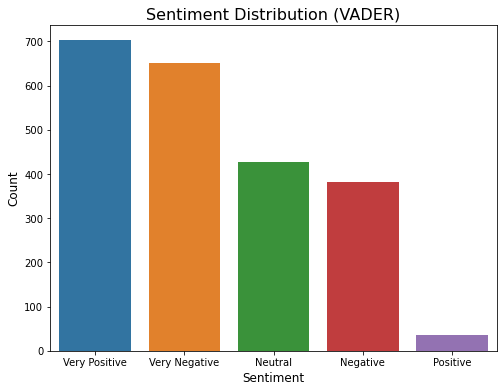

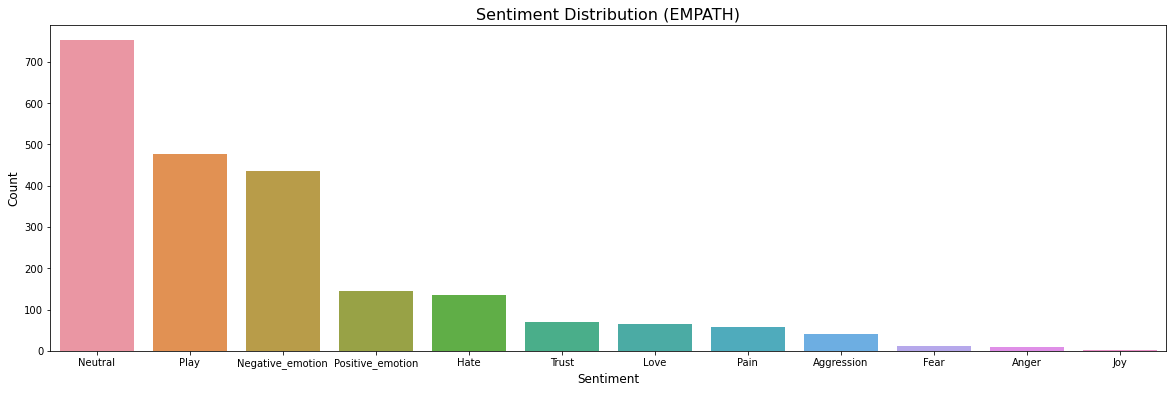

In [167]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Additional insights 
def get_top_words(df, sentiment, column, n=5):
    comments = df[df[column] == sentiment]["Comment"]
    words = [word for comment in comments for word in comment.split()]
    word_counts = Counter(words)
    return word_counts.most_common(n)

df = pd.read_csv("Sentimental_analysis_VADER_EMPATH.csv")



# Top 5 most common words used in each sentiment category for VADER
print("Top 5 words for each VADER sentiment category:")
for sentiment in sentiment_averages:
    top_words = get_top_words(df, sentiment, "Overall_VADER_sentiment")
    print(f"{sentiment}: {top_words}")

print()

# Top 5 most common words used in each sentiment category for EMPATH
print("Top 5 words for each EMPATH sentiment category:")
for sentiment in empath_sentiment_averages:
    top_words = get_top_words(df, sentiment, "Overall_EMPATH_sentiment")
    print(f"{sentiment}: {top_words}")

print()


plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Sentiment Distribution (VADER)", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()




plt.figure(figsize=(20, 6))
sns.barplot(x=empath_sentiment_counts.index, y=empath_sentiment_counts.values)
plt.title("Sentiment Distribution (EMPATH)", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()







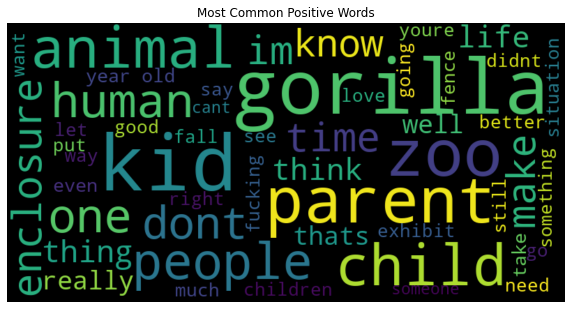

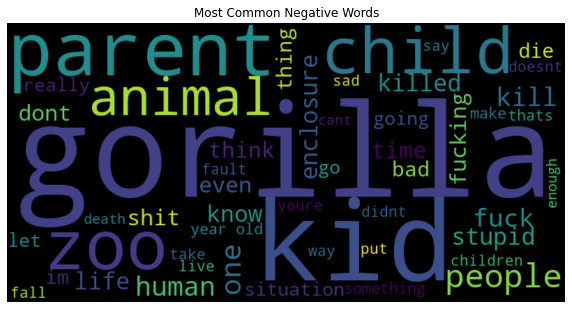

In [154]:
# Word cloud showing most common words used in comments
from wordcloud import WordCloud

positive_words = ' '.join(df[df['Overall_VADER_sentiment']=='Very Positive']['Comment'].values)
negative_words = ' '.join(df[df['Overall_VADER_sentiment']=='Very Negative']['Comment'].values)

plt.figure(figsize=(10,6))
plt.imshow(WordCloud(width=800, height=400, max_words=50).generate(positive_words), interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Positive Words')
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(WordCloud(width=800, height=400, max_words=50).generate(negative_words), interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Negative Words')
plt.show()


In [161]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pandas as pd

# Load the preprocessed data
processed_df = pd.read_csv("Sentimental_analysis_processeddata.csv")

# Tokenize the comments
tokenized_comments = processed_df["Comment"].apply(lambda x: x.split())

# Create a dictionary and a corpus from the tokenized comments
dictionary = corpora.Dictionary(tokenized_comments)
corpus = [dictionary.doc2bow(comment) for comment in tokenized_comments]

# Train the LDA model
num_topics = 5
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20, random_state=42)

# Display the top keywords for each topic
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")


Topic: 0 
Words: 0.019*"parents" + 0.017*"kid" + 0.012*"zoo" + 0.012*"child" + 0.010*"dont" + 0.010*"know" + 0.009*"year" + 0.008*"could" + 0.008*"get" + 0.008*"kids"

Topic: 1 
Words: 0.014*"people" + 0.008*"animals" + 0.008*"like" + 0.007*"zoo" + 0.007*"take" + 0.007*"one" + 0.006*"reason" + 0.006*"go" + 0.005*"let" + 0.005*"probably"

Topic: 2 
Words: 0.015*"like" + 0.013*"youre" + 0.011*"kid" + 0.010*"people" + 0.007*"get" + 0.007*"time" + 0.007*"dont" + 0.007*"life" + 0.007*"one" + 0.006*"really"

Topic: 3 
Words: 0.028*"gorilla" + 0.015*"would" + 0.015*"gorillas" + 0.014*"humans" + 0.014*"human" + 0.012*"kill" + 0.011*"species" + 0.010*"life" + 0.009*"one" + 0.008*"people"

Topic: 4 
Words: 0.031*"gorilla" + 0.018*"child" + 0.015*"parents" + 0.013*"zoo" + 0.009*"zoos" + 0.009*"fault" + 0.009*"animal" + 0.008*"enclosure" + 0.008*"think" + 0.008*"dont"



In [156]:

# Assign the dominant topic for each comment
def dominant_topic(ldamodel, corpus):
    dominant_topic_list = []
    for doc in corpus:
        topic_probs = ldamodel.get_document_topics(doc)
        dominant_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topic_list.append(dominant_topic)
    return dominant_topic_list

processed_df["Dominant_topic"] = dominant_topic(lda_model, corpus)

# Perform VADER sentiment analysis
sia = SentimentIntensityAnalyzer()
processed_df["Sentiment"] = processed_df["Comment"].apply(lambda x: sia.polarity_scores(x)["compound"]).apply(classify_sentiment)

# Analyze the sentiment distribution for each topic
sentiment_by_topic = processed_df.groupby(["Dominant_topic", "Sentiment"]).size().unstack()
sentiment_distribution = sentiment_by_topic.apply(lambda x: x / x.sum(), axis=1)
print(sentiment_distribution)


Sentiment       Negative   Neutral  Positive  Very Negative  Very Positive
Dominant_topic                                                            
0               0.172161  0.163614  0.023199       0.300366       0.340659
1               0.150685  0.188356  0.010274       0.294521       0.356164
2               0.158209  0.256716  0.011940       0.241791       0.331343
3               0.197917  0.226562  0.020833       0.294271       0.260417
4               0.185484  0.180108  0.005376       0.336022       0.293011


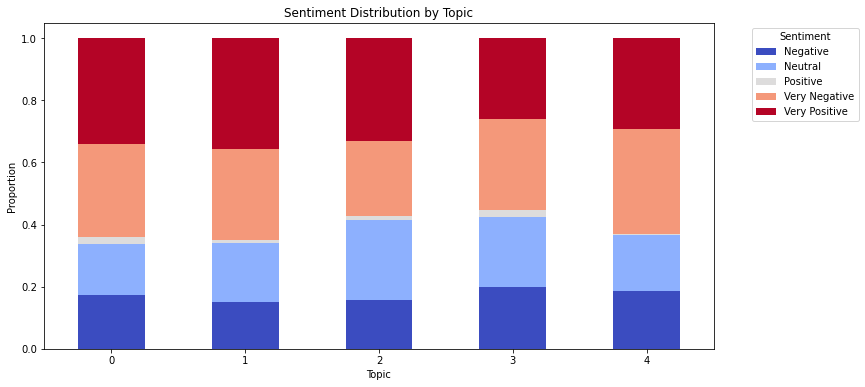

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_topic_keywords(ldamodel, num_topics):
    topic_keywords = {}
    for idx, topic in ldamodel.show_topics(num_topics, formatted=False):
        topic_keywords[idx] = ", ".join([word[0] for word in topic])
    return topic_keywords

topic_keywords = get_topic_keywords(lda_model, num_topics)

def plot_sentiment_distribution(df, title, topic_keywords):
    ax = df.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
    ax.set_xlabel("Topic")
    ax.set_ylabel("Proportion")
    ax.set_title(title)
    ax.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

    
    plt.xticks(rotation=0)
    

    plt.show()

plot_sentiment_distribution(sentiment_distribution, "Sentiment Distribution by Topic", topic_keywords)



In [160]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare the visualization data
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the interactive visualization
pyLDAvis.display(vis_data)


C:\Users\sindh\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
